# MW-M31 Post-Merger Remnant: rotations

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Specific-angular-momentum" data-toc-modified-id="Specific-angular-momentum-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Specific angular momentum</a></span><ul class="toc-item"><li><span><a href="#Halo-angular-momentum" data-toc-modified-id="Halo-angular-momentum-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Halo angular momentum</a></span><ul class="toc-item"><li><span><a href="#Halo-time-course" data-toc-modified-id="Halo-time-course-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Halo time course</a></span></li></ul></li><li><span><a href="#Spin-parameter-$\lambda$" data-toc-modified-id="Spin-parameter-$\lambda$-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Spin parameter $\lambda$</a></span></li></ul></li><li><span><a href="#Velocity-dispersion" data-toc-modified-id="Velocity-dispersion-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Velocity dispersion</a></span></li></ul></div>

## Setup

In [1]:
# import modules
import numpy as np
from numpy.linalg import norm
from scipy.optimize import curve_fit
import pandas as pd
import astropy.units as u
from astropy.constants import G
from astropy.cosmology import Planck15, z_at_value

# import plotting modules
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mpl_scatter_density
from matplotlib import rcParams
from matplotlib.patches import Ellipse
# 
# Make the norm object to define the image stretch
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
im_norm = ImageNormalize(vmin=0., vmax=1000, stretch=LogStretch())

%matplotlib inline

In [2]:
# my modules
from galaxy.galaxy import Galaxy
from galaxy.centerofmass import CenterOfMass
from galaxy.massprofile import MassProfile
from galaxy.plots import Plots
from galaxy.timecourse import TimeCourse
from galaxy.utilities import find_nearest, rotation_matrix_to_vector

from galaxy.remnant import Remnant
from galaxy.remvdisp import Vdisp

In [3]:
tc = TimeCourse()
p = Plots()

## Specific angular momentum 

### Halo angular momentum

Get just the DM particles (type=1) for the remnant at the last time point:

In [4]:
remn_halo = Remnant(usesql=True, ptype=1)

In [5]:
com = CenterOfMass(remn_halo, ptype=None) 
com_p = com.com_p()
com_v = com.com_v(com_p)
xyz_h, vxyz_h = com.center_com()
m = remn_halo.data['m']

In [6]:
radii = np.arange(10, 350, 5)
L, h = com.sphere_h(radii, m, xyz_h, vxyz_h)

In [7]:
# def plot_h_r(radii, h, xmax=350, figsize=(8,6), ylabel='$h$ within radius',
#              pngout=False, fname=None):
#     fontsize = 24
#     fig = plt.figure(figsize=figsize)
#     plt.plot(radii, norm(h, axis=1), 'b-', lw=3)
#     plt.xlabel('r (kpc)', fontsize=fontsize)
#     plt.ylabel(ylabel, fontsize=fontsize)
#     plt.xlim(0, xmax),
#     # plt.ylim(0, 3000)

#     label_size = 16
#     matplotlib.rcParams['xtick.labelsize'] = label_size 
#     matplotlib.rcParams['ytick.labelsize'] = label_size

#     plt.tight_layout()
#     if pngout:
#         plt.savefig(fname, rasterized=True, dpi=350);

In [8]:
# def plot_theta_phi(radii, theta, phi, xmax=350, figsize=(8,6),
#              pngout=False, fname=None):
#     fontsize = 24
#     fig = plt.figure(figsize=figsize)
#     plt.plot(radii, theta, 'r:', lw=3, label=r'$\theta$ (polar)')
#     plt.plot(radii, phi, 'b-', lw=3, label=r'$\phi$ (azimuthal)')
#     plt.xlabel('r (kpc)', fontsize=fontsize)
#     plt.ylabel('$\hat{L}$ angles (deg)', fontsize=fontsize)
#     plt.xlim(0, xmax)
#     # plt.ylim(40, 90)

#     plt.legend(fontsize='xx-large', shadow=True)
#     plt.tight_layout()

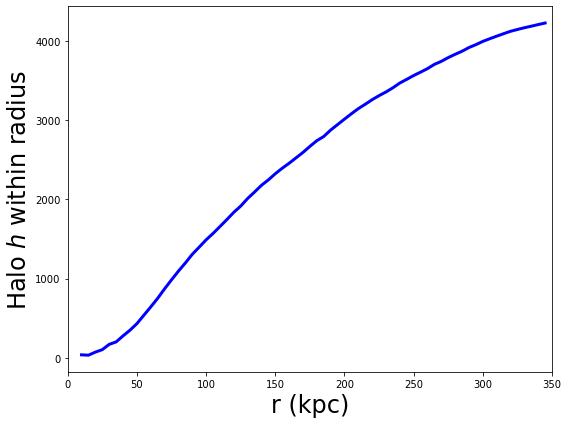

In [9]:
p.plot_h_r(radii, h, ylabel='Halo $h$ within radius')

In [10]:
L_hat = L / norm(L, axis=1)[:,np.newaxis]
phi = np.arctan2(L_hat[:,1], L_hat[:,0]) * 180/np.pi
theta = np.arccos(L_hat[:,2]) * 180/np.pi

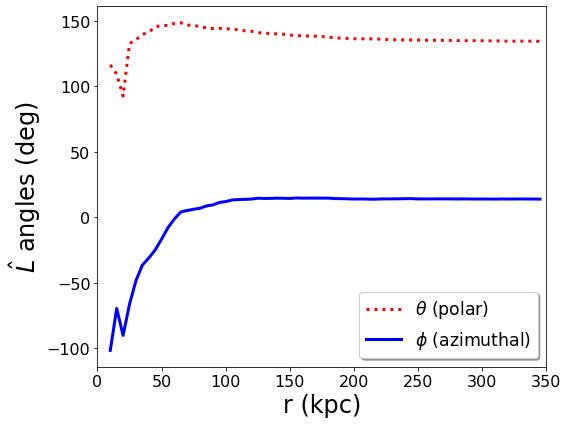

In [11]:
p.plot_theta_phi(radii, theta, phi)

#### Halo time course

In [12]:
def halo_angmom(m, xyz, vxyz):
    L = np.sum(np.cross(xyz, m*vxyz, axis=0), axis=1)
    h = L / np.sum(m)

    return h.to(u.kpc**2/u.Myr)

In [13]:
def galaxy_halo_angmom(gal, snap):
    g = Galaxy(gal, snap=snap, ptype=1, usesql=True)
    com_xyz, com_vxyz = tc.get_one_com(gal, snap)
    xyz = (g.xyz() - com_xyz[:, np.newaxis]) * u.kpc
    vxyz = (g.vxyz() - com_vxyz[:, np.newaxis]) * u.km/u.s
    m = g.data['m']
    h = halo_angmom(m, xyz, vxyz)
    halo_mag = norm(h)
    halo_unit = (h/halo_mag).value
    return halo_unit, halo_mag

Write all values to text file (slow!):

In [14]:
# with open('./halo_h.txt', 'w') as f:
#     f.write(f"# {'gal':>5s}{'snap':>8s}{'t':>8s}{'h_x':>8s}{'h_y':>8s}{'h_z':>8s}{'h_mag':>8s}\n")
    
# for galname in ('MW','M31','M33'):
#     print(galname)
#     for snap in np.arange(0, 802):
#         t = tc.snap2time(snap)
#         (hx, hy, hz), h_mag = galaxy_halo_angmom(galname, snap)
#         with open('./halo_h.txt', 'a') as f:
#             f.write(f"{galname:>7s}{snap:8d}{t:8.3f}{hx:8.2f}{hy:8.2f}{hz:8.2f}{h_mag.value:8.3f}\n")   

Read the data back in and plot it:

In [15]:
halo_h = np.genfromtxt('halo_h.txt', names=True, skip_header=0,
                    dtype=[('gal', 'U3'), ('snap', '<i8'), ('t', '<f8'), ('h_x', '<f8'), 
                           ('h_y', '<f8'), ('h_z', '<f8'), ('h_mag', '<f8')])

In [16]:
MW = halo_h[halo_h['gal'] == 'MW']
M31 = halo_h[halo_h['gal'] == 'M31']
M33 = halo_h[halo_h['gal'] == 'M33']

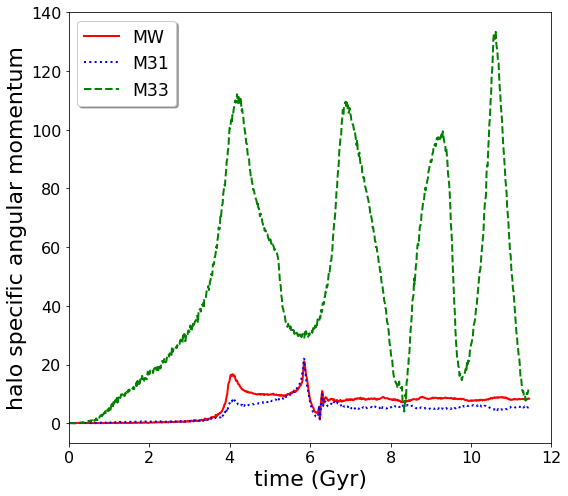

In [17]:
fig = plt.figure(figsize=(8,7))
ax0 = plt.subplot()

# add the curves
n = 1 # plot every n'th time point
ax0.plot(MW['t'][::n], MW['h_mag'][::n], 'r-', lw=2, label='MW')
ax0.plot(M31['t'][::n], M31['h_mag'][::n], 'b:', lw=2, label='M31')
ax0.plot(M33['t'][::n], M33['h_mag'][::n], 'g--', lw=2, label='M33')

ax0.legend(fontsize='xx-large', shadow=True)

# Add axis labels
ax0.set_xlabel("time (Gyr)", fontsize=22)
ax0.set_ylabel("halo specific angular momentum", fontsize=22)

ax0.set_xlim(0,12)
# ax0.set_ylim(0,6)

#adjust tick label font size
label_size = 22
rcParams['xtick.labelsize'] = label_size 
rcParams['ytick.labelsize'] = label_size

plt.tight_layout()
plt.savefig('halo_h.pdf', rasterized=True, dpi=350);

### Spin parameter $\lambda$

In [18]:
def halo_L(m, xyz, vxyz):
#     print(m.shape, xyz.shape, vxyz.shape)
    L = np.sum(np.cross(xyz, m*vxyz, axis=0), axis=1)
#     print(L.shape)

    return L.to(u.Msun * u.kpc**2/u.Myr)

In [19]:
def remnant_halo_data(snap):
    # some objects
    rem = Remnant(snap=snap, ptype=(1,2,3), usesql=True)
    com = CenterOfMass(rem)
    mp = MassProfile(rem)
    
    # find CoM for disk particles
    com_xyz = com.com_p()
    com_vxyz = com.com_v(com_xyz)
    
    # center coordinates
    xyz = rem.xyz() * u.kpc - com_xyz[:, np.newaxis]
    vxyz = rem.vxyz() * u.km/u.s - com_vxyz[:, np.newaxis]
    
    # mass and distance from CoM
    m = rem.data['m'] * 1e10 * u.Msun
    r = norm(xyz, axis=0)
    
    # virial radius (using current rho_c)
    r_200 = mp.virial_radius()
    
    # we just want DM particles inside r_200
    wanted = np.where((rem.data['type'] == 1) & (r.value < r_200))
    m_dm = m[wanted]
    xyz_dm = xyz.T[wanted].T
    vxyz_dm = vxyz.T[wanted].T
    r_dm = r[wanted]
    
    # angular momentum
    L = halo_L(m_dm, xyz_dm, vxyz_dm)
    L_mag = norm(L)
    L_unit = (L/L_mag).value
    
    # kinetic energy
    v = norm(vxyz_dm)
    K = np.sum(m_dm * v**2) / 2
    
    # halo mass
    M = np.sum(m_dm)
    
    return L_unit, L_mag, K, M

In [20]:
# with open('./halo_L.txt', 'w') as fL:
#     fL.write(f"# {'snap':>8s}{'t':>8s}{'L_x':>8s}{'L_y':>8s}{'L_z':>8s}{'L_mag':>10s}\n")
    
# with open('./halo_K.txt', 'w') as fK:
#     fK.write(f"# {'snap':>8s}{'t':>8s}{'K':>10s}{'m_200':>12s}\n")
    
# for snap in np.arange(440, 802):
#     t = tc.snap2time(snap)
#     (Lx, Ly, Lz), L_mag, K, M = remnant_halo_data(snap)
#     with open('./halo_L.txt', 'a') as fL:
#         fL.write(f"{snap:10d}{t:8.3f}{Lx:8.2f}{Ly:8.2f}{Lz:8.2f}{L_mag.value:12.3e}\n")   
#     with open('./halo_K.txt', 'a') as fK:
#         fK.write(f"{snap:10d}{t:8.3f}{K.value:12.3e}{M.value:12.3e}\n")           

In [21]:
rem_halo_L = np.genfromtxt('halo_L.txt', names=True, skip_header=0,
                    dtype=[('snap', '<i8'), ('t', '<f8'), ('L_x', '<f8'), 
                           ('L_y', '<f8'), ('L_z', '<f8'), ('L_mag', '<f8')])

In [22]:
rem_halo_K = np.genfromtxt('halo_K.txt', names=True, skip_header=0,
                    dtype=[('snap', '<i8'), ('t', '<f8'), ('K', '<f8'), ('M', '<f8')])

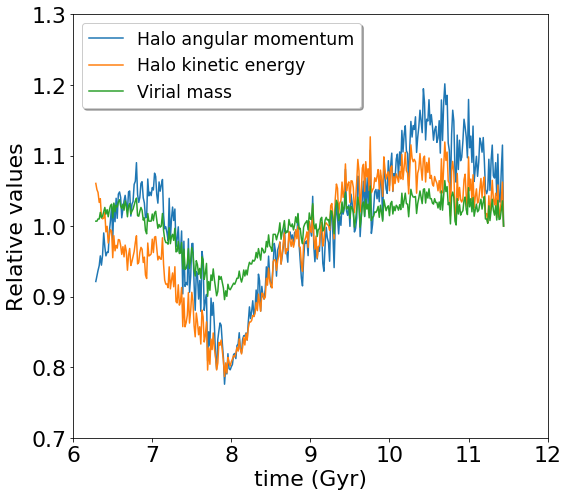

In [23]:
fig = plt.figure(figsize=(8,7))
plt.plot(rem_halo_L['t'], rem_halo_L['L_mag']/rem_halo_L['L_mag'][-1], 
         label='Halo angular momentum')
plt.plot(rem_halo_K['t'], rem_halo_K['K']/rem_halo_K['K'][-1], 
         label='Halo kinetic energy')
plt.plot(rem_halo_K['t'], rem_halo_K['m_200']/rem_halo_K['m_200'][-1], 
         label='Virial mass')
plt.legend(fontsize='xx-large', shadow=True)

# Add axis labels
plt.xlabel("time (Gyr)", fontsize=22)
plt.ylabel("Relative values", fontsize=22)

plt.xlim(6,12)
plt.ylim(0.7,1.3)

# ax0.set_title("Hernquist scale radius", fontsize=24)
#adjust tick label font size
label_size = 22
rcParams['xtick.labelsize'] = label_size 
rcParams['ytick.labelsize'] = label_size

plt.tight_layout()
plt.savefig('halo_data.pdf', rasterized=True, dpi=350);

In [24]:
L_unit, L_mag, K, M = remnant_halo_data(801)

In [25]:
L_unit, L_mag, K, M

(array([ 0.6833631 ,  0.17246601, -0.7094155 ], dtype=float32),
 <Quantity 7.731781e+12 kpc2 solMass / Myr>,
 <Quantity 1.53370389e+22 km2 solMass / s2>,
 <Quantity 2.0329841e+12 solMass>)

In [26]:
from astropy.constants import G
G = G.to(u.kpc**2/ u.Msun / u.Myr * u.km / u.s)
G

<Quantity 4.39860041e-09 km kpc2 / (Myr s solMass)>

In [27]:
lambd = L_mag * np.sqrt(K) / (G * M**2.5)
lambd

<Quantity 36.94033462>

In [28]:
K.to(u.erg), K.to(u.Msun*u.kpc**2/u.Myr**2)

(<Quantity 3.04963196e+65 erg>, <Quantity 1.60416251e+16 kpc2 solMass / Myr2>)

## Velocity dispersion

In [29]:
def process_snap(snap, xlim):
    vdisp = Vdisp(snap, ptype=1, r_lim=xlim)
    xbins = np.linspace(-(xlim-1), (xlim-1), 100)
    vdisp.set_xbins(xbins)

    fname = f'remnant_dm_disp_y_{snap:03}.png'
    vdisp.plot_yx(particles='DM', xlim=(-xlim, xlim), ylim1=(-50, 50), ylim2=(0,250), 
                  pngout=True, fname=fname)
    plt.close()
    fname = f'remnant_dm_disp_z_{snap:03}.png'
    vdisp.plot_zx(particles='DM', xlim=(-xlim, xlim), ylim1=(-50, 50), ylim2=(0,250), 
                  pngout=True, fname=fname)
    plt.close()
    
    return vdisp.vmax_yx, vdisp.sigma_central_yx

The next cell is SLOW:

In [30]:
# vals_yx = []
# for snap in np.arange(430, 802):
# # for snap in (420, 600, 801):
#     print(snap, end=' ')
#     vmax_yx, sigma_central_yx = process_snap(snap, 150)
#     vals_yx.append( (snap, vmax_yx, sigma_central_yx) )
# vals_yx

In [32]:
# np.save('dm_vdisp_yx', vals_yx)

In [36]:
loaded = np.load('dm_vdisp_yx.npy')
loaded

array([[430.        ,  34.57031823, 172.81162225],
       [431.        ,  34.61299297, 179.07437685],
       [432.        ,  35.18570215, 176.98196106],
       ...,
       [799.        ,  33.60289112, 175.45011086],
       [800.        ,  33.75408989, 179.20273713],
       [801.        ,  32.62289804, 177.80143231]])

In [37]:
snaps = loaded[:,0]
t = np.array([tc.snap2time(s) for s in snaps])
vmax_yx = loaded[:,1]
sigma_central_yx = loaded[:,2]

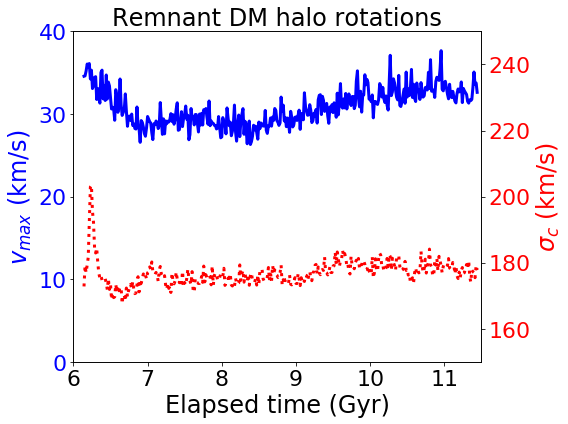

In [53]:
fontsize = 24
fig, ax1 = plt.subplots(figsize=(8,6))

color = 'blue'
ax1.plot(t, vmax_yx, 'b-', lw=3, label=r'$v_{max}$ along $y$')
ax1.set_xlabel('Elapsed time (Gyr)', fontsize=fontsize)
ax1.set_ylabel('$v_{max}$ (km/s)', color=color, fontsize=fontsize)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlim(6, 11.5)
ax1.set_ylim(0, 40)

ax2 = ax1.twinx()  # shares the same x-axis as ax1

color = 'red'
ax2.plot(t, sigma_central_yx, 'r:', lw=3, label=r'$\sigma_c$')
ax2.set_ylabel('$\sigma_c$ (km/s)', color=color, fontsize=fontsize)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(150, 250)

# ax1.legend(fontsize='xx-large', shadow=True)
ax1.set_title('Remnant DM halo rotations', fontsize=24)
plt.tight_layout()
plt.savefig('rem_dm_vdisp_tc.pdf', rasterized=True, dpi=350);

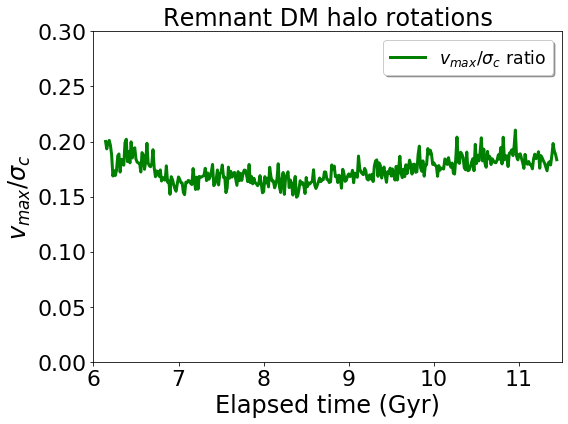

In [54]:
fontsize = 24
fig = plt.figure(figsize=(8,6))
plt.plot(t, vmax_yx/sigma_central_yx, 'g-', lw=3, label=r'$v_{max}$/$\sigma_c$ ratio')
# plt.plot((6, 11.5), (0.6,0.6), 'k:', lw=3, alpha=0.5)
plt.xlabel('Elapsed time (Gyr)', fontsize=fontsize)
plt.ylabel(r'$v_{max} / \sigma_c$', fontsize=fontsize)
plt.xlim(6, 11.5)
plt.ylim(0, 0.3)

plt.legend(fontsize='xx-large', shadow=True)
plt.title('Remnant DM halo rotations', fontsize=24)
plt.tight_layout()
plt.savefig('rem_dm_vdisp_ratio.pdf', rasterized=True, dpi=350);